# Feature Selection and Model Development

In [1]:
# Import packages 
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import binarize
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score


In [2]:
#import and stack
orders_prior = pd.read_csv("order_products__prior.csv")
orders_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
clusters = pd.read_csv("User Clusters.csv")
clusters.drop(clusters.columns[0], axis = 1, inplace = True)
products_id = pd.read_csv("products.csv")


In [3]:
#Split data
prior = orders_prior.merge(orders, on = 'order_id', how = 'left')
del orders_prior

#save copy
prior_original = prior.copy()


### Feature Selection and Engineering

In [4]:
#Simple Features Function
def group_and_attach(df, df_new, group, value, method, name):
    
    if name in df_new.columns:
        df_new = df_new
    
    else:
        df_grouped = df.groupby(group)[value].agg(method).reset_index()
        df_grouped.columns.values[-1] = name

        df_new = pd.merge(df_new, df_grouped, on = group, how = 'left')

    return df_new
    
#Create function that calculates likelihood for item to be reordered
def first_buy(x): return sum(x == 1)
def second_buy(x): return sum(x == 2)

def second_reorder(df, df_new, group, column, name):
    grouped = df.groupby(group)
    second_reorder = grouped.agg({column : [first_buy, second_buy]})
    second_reorder.columns = second_reorder.columns.droplevel()
    second_reorder[name] = second_reorder['second_buy']/second_reorder['first_buy']
    second_reorder = second_reorder.reset_index()
    df_new = df_new.merge(second_reorder[[group, name]], on = group, how = 'left')

    return df_new

In [5]:
prior.columns

#Create empty datasets
users = pd.DataFrame(prior['user_id']).drop_duplicates()
products = pd.DataFrame(prior['product_id']).drop_duplicates()
user_products = prior[['user_id', 'product_id']].drop_duplicates()

### User Features

In [6]:
#Simple features
parameters = [['user_id', 'product_id', 'count', 'total_purchases_by_user'], #purchases by user
              ['user_id', 'reordered', 'sum', 'total_reorders_by_user'], #reorders by user
              ['user_id', 'order_number', 'max', 'total_orders'], #Total orders by user
              ['user_id', 'days_since_prior_order', 'mean', 'mean_days_btwn_orders'],
              ['user_id', 'add_to_cart_order', 'mean', 'avg_cart_size']]


for param in parameters:
    users = group_and_attach(prior, users, *param)
    
#Additional Features
users['user_reorder_rate'] = users['total_reorders_by_user']/users['total_purchases_by_user']


#Number of days since first order
days = prior[['user_id', 'order_id', 'days_since_prior_order']].drop_duplicates()
users = group_and_attach(days, users, 'user_id', 'days_since_prior_order', 'sum', 'days_since_first_order')

#Number of distinct items bought per user
grouped = prior.groupby(['user_id', 'product_id']).count().groupby('user_id')['order_id'].count().reset_index()
grouped.columns = ['user_id', 'num_unique_products']
users = users.merge(grouped, on = 'user_id')

#What is the likelihood of reordering a product after ordering it for the first time
#Cumulative count
prior = prior.sort_values(by = ['user_id', 'order_id'])
prior.loc[:,'user_buy_product_times'] = prior.groupby(['user_id', 'product_id']).cumcount() + 1

#create columns for number of items bought for the first and second time
users = second_reorder(prior, users, 'user_id', 'user_buy_product_times', 'user_second_reorder')

users.head()

,user_id,total_purchases_by_user,total_reorders_by_user,total_orders,mean_days_btwn_orders,avg_cart_size,user_reorder_rate,days_since_first_order,num_unique_products,user_second_reorder
0,202279,90,43,8,21.862500,6.411111,0.477778,151.0,47,0.340426
1,205970,323,190,25,9.805825,7.835913,0.588235,221.0,133,0.390977
2,178520,923,816,56,6.740659,9.756230,0.884074,357.0,107,0.663551
3,156122,967,813,52,6.966351,10.561531,0.840745,342.0,154,0.701299
4,22352,91,8,8,23.670455,7.923077,0.087912,166.0,83,0.084337


### Product Features

In [7]:
parameters = [['product_id', 'user_id', 'count', 'total_purchases_prod'], #total purchases by product
              ['product_id', 'reordered', 'sum', 'total_reorders_prod']] #total reorders by product
              
for param in parameters:
    products = group_and_attach(prior, products, *param)

    
#Reorder rate by product    
products['reorder_rate_prod'] = products['total_reorders_prod']/products['total_purchases_prod'] 

#How likely is a specific product to be bought a second time
prior = prior.sort_values(by = ['product_id', 'order_id'])
prior.loc[:,'product_buy_times'] = prior.groupby(['product_id', 'user_id']).cumcount() + 1

#How likely is a product to be reordered after it was ordered for the first time?
products = second_reorder(prior, products, 'product_id', 'product_buy_times', 'prods_second_reorder')
    
#Number of distinct users that have purchased a product
grouped = prior.groupby(['product_id', 'user_id']).count().groupby('product_id')['order_id'].count().reset_index()
grouped.columns = ['product_id', 'num_unique_users']
products = products.merge(grouped, on = 'product_id')

#percent of times a product appeared in all users last 5 orders - determine recent popularity
orders_last5 = orders.groupby(['user_id']).tail(5)
grouped = (prior[prior['order_id'].isin(orders_last5['order_id'])]
           .groupby('product_id').agg({'order_id' : 'count'}).reset_index().sort_values(by = 'order_id', ascending = False))

grouped['prod_popularity'] = grouped['order_id']/len(orders_last5)
products = products.merge(grouped[['product_id', 'prod_popularity']], on = 'product_id', how = 'left')
del orders_last5        

products.head()

,product_id,total_purchases_prod,total_reorders_prod,reorder_rate_prod,prods_second_reorder,num_unique_users,prod_popularity
0,33120,19400,13744,0.708454,0.554809,5656,0.004861
1,28985,67449,46841,0.694465,0.542653,20608,0.016027
2,9327,6299,995,0.157962,0.120098,5304,0.001742
3,45918,744,203,0.272849,0.188540,541,0.000194
4,30035,569,289,0.507909,0.367857,280,0.000151


### User by Product Features

In [8]:
#For each product id - need to determine things like likelihood of reordering per user
#counts of total orders by product and user
#counts of total reorders by product and user
parameters = [[['product_id', 'user_id'], 'order_id', 'count', 'total_purchases_prodXuser'], #total purchases by product
              [['product_id', 'user_id'], 'reordered', 'sum', 'total_reorders_prodXuser'], #total reorders by product
              [['product_id', 'user_id'], 'add_to_cart_order', 'mean', 'avg_product_pos']]
              
for param in parameters:
    user_products = group_and_attach(prior, user_products, *param)


#reorder rate by product and user
user_products['reorder_rate_prodXuser'] = user_products['total_reorders_prodXuser']/user_products['total_purchases_prodXuser']

#for each user, how often has each product appeared in last 10 orders
orders_last5 = orders.groupby(['user_id']).tail(5)
grouped = (prior[prior['order_id'].isin(orders_last5['order_id'])]
           .groupby(['user_id','product_id']).agg({'order_id' : 'count'}).reset_index())
grouped['prodXuser_popularity'] = grouped['order_id']/5
user_products = user_products.merge(grouped[['user_id', 'product_id', 'prodXuser_popularity']], 
                                    on = ['user_id','product_id'], how = 'left')
del orders_last5

user_products.head()

,user_id,product_id,total_purchases_prodXuser,total_reorders_prodXuser,avg_product_pos,reorder_rate_prodXuser,prodXuser_popularity
0,202279,33120,5,4,2.000000,0.800000,0.6
1,202279,28985,5,4,3.200000,0.800000,0.4
2,202279,9327,1,0,3.000000,0.000000,NaN
3,202279,45918,5,4,4.800000,0.800000,0.6
4,202279,30035,3,2,4.666667,0.666667,0.4


### Create Train/Test Dataset and Release Memory

Model data should be unique on user and product ID. Goal is to provide as much information as possible for these pairwise combinations. Predicting likelihood of reorder for each of these combinations.

In [10]:
orders_train = orders_train.merge(orders, on = 'order_id', how = 'left')
orders_train['reordered'] = orders_train['reordered'].astype(int)
train_test = (user_products.merge(users, on = 'user_id', how = 'left')
             .merge(products, on = 'product_id', how = 'left')
             .merge(orders[orders['eval_set'] != 'prior'], on = 'user_id', how = 'inner') #Subset to only train and test
             .merge(products_id, on = 'product_id', how = 'left')
             .merge(orders_train[['user_id', 'product_id', 'reordered']], on = ['user_id', 'product_id'], how = 'left')
             .merge(clusters, on = 'user_id', how = 'left'))
train_test = train_test.fillna(0)

train = train_test[train_test['eval_set'] == 'train']
test = train_test[train_test['eval_set'] == 'test']

del prior, users, products, user_products, orders, clusters, orders_train, train_test, grouped

#Save datasets for easy access later
train.to_csv("Train Dataset.csv", encoding = 'utf8')
test.to_csv("Test Dataset.csv", encoding = 'utf8')


In [6]:
train = pd.read_csv("Train Dataset.csv", encoding = 'utf8')
#test = pd.read_csv("Test Dataset.csv", encoding = 'utf8')

#for testing purposes subset to first 9999 users
#train = train[train['user_id'] < 10000]
train.columns

Index(['Unnamed: 0', 'user_id', 'product_id', 'total_purchases_prodXuser',
       'total_reorders_prodXuser', 'avg_product_pos', 'reorder_rate_prodXuser',
       'prodXuser_popularity', 'total_purchases_by_user',
       'total_reorders_by_user', 'total_orders', 'mean_days_btwn_orders',
       'avg_cart_size', 'user_reorder_rate', 'days_since_first_order',
       'num_unique_products', 'user_second_reorder', 'total_purchases_prod',
       'total_reorders_prod', 'reorder_rate_prod', 'prods_second_reorder',
       'num_unique_users', 'prod_popularity', 'order_id', 'eval_set',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id',
       'reordered', 'cluster'],
      dtype='object')

### Tune Parameters

In [5]:
#Create list of features
#There are a lot more features that could and should be made, but I am keeping this model light
#e.g. likelihood to reorder an item in specific aisle or department after ordering it for the first time,
#labeling perishable food, or some features related to days since prior order

features = ['order_dow', 'order_hour_of_day', 'days_since_prior_order',
           'cluster', 'total_purchases_by_user', 'user_reorder_rate', 'total_orders', 
            'mean_days_btwn_orders', 'avg_cart_size', 'num_unique_products', 
           'user_second_reorder', 'total_purchases_prod', 'reorder_rate_prod','avg_product_pos',
            'total_purchases_prodXuser',  'reorder_rate_prodXuser',
           'prods_second_reorder', 'num_unique_users', 'prod_popularity',  'prodXuser_popularity']

#Model performs worse with aisle_id and department_id as categorical features

#Split to tune paramaters and find optimal threshold
x_train, x_test, y_train, y_test = train_test_split(train[features], train['reordered'], random_state = 0)

#Create parameters to gridsearch through - use defaults for the others. 
grid_params = {
    'learning_rate' : [0.005, 0.01],
    'num_leaves' : [25, 50, 100],
    'max_depth' : [10, 15, 20],
    'num_iterations' : [10, 15, 20],
}

#Create classifier
clf = lgb.LGBMClassifier(boosting_type = 'gbdt',
                         objective = 'binary',
                         metric = 'binary_logloss',
                         feature_fraction = 0.90,
                         bagging_fraction = 0.90,
                         bagging_freq = 5)

grid_search = GridSearchCV(estimator = clf, param_grid = grid_params, scoring = 'f1', n_jobs = 4, cv = 5)

grid_search.fit(x_train, y_train)

grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_

C:\Users\abell\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\abell\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.23691, std: 0.01628, params: {'learning_rate': 0.005, 'max_depth': 15, 'num_iterations': 10, 'num_leaves': 50},
  mean: 0.25106, std: 0.00387, params: {'learning_rate': 0.005, 'max_depth': 15, 'num_iterations': 10, 'num_leaves': 100},
  mean: 0.23790, std: 0.01838, params: {'learning_rate': 0.005, 'max_depth': 15, 'num_iterations': 15, 'num_leaves': 50},
  mean: 0.25015, std: 0.00713, params: {'learning_rate': 0.005, 'max_depth': 15, 'num_iterations': 15, 'num_leaves': 100},
  mean: 0.23691, std: 0.01628, params: {'learning_rate': 0.005, 'max_depth': 20, 'num_iterations': 10, 'num_leaves': 50},
  mean: 0.25106, std: 0.00387, params: {'learning_rate': 0.005, 'max_depth': 20, 'num_iterations': 10, 'num_leaves': 100},
  mean: 0.23790, std: 0.01838, params: {'learning_rate': 0.005, 'max_depth': 20, 'num_iterations': 15, 'num_leaves': 50},
  mean: 0.25015, std: 0.00713, params: {'learning_rate': 0.005, 'max_depth': 20, 'num_iterations': 15, 'num_leaves': 100},
  mean: 0.23678, std

### Run initial model to determine baseline and feature importance

C:\Users\abell\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


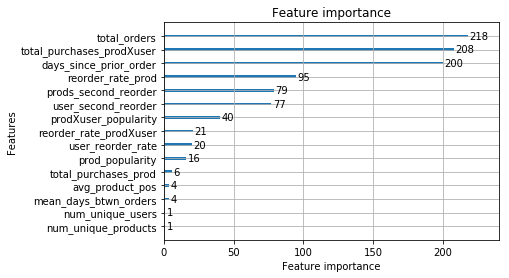

[ 0.45777329  0.46853143  0.46176151 ...,  0.45619623  0.49198782
  0.46677675]
F1 Score with default threshold: 0.252266820676


In [9]:
x_train, x_test, y_train, y_test = train_test_split(train[features], train['reordered'], random_state = 0)

#Parameters
params = {
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'feature_fraction' : 0.7,
    'bagging_fraction' : 0.85,
    'bagging_freq' : 5,
    'min_data_in_leaf' : 10
}
#Select the best parameters for my model
params['learning_rate'] = .01 #grid_search.best_params_['learning_rate']
params['num_leaves'] = 100 #grid_search.best_params_['num_leaves']
params['max_depth'] = 15 #grid_search.best_params_['max_depth']
params['num_iterations'] = 10 #grid_search.best_params_['num_iterations'] 


lgb_df = lgb.Dataset(x_train, label = y_train)

gbm = lgb.train(params, lgb_df, num_boost_round = 100)
#gbm.save_model(model_file) #May need to import pickle

#Print feature importances
lgb.plot_importance(gbm)
plt.show() #import matlib

preds = gbm.predict(x_test, num_iteration = gbm.best_iteration)
    
#curious what F1 score is without deciding threshold
print(preds)
print("F1 Score with default threshold: " + str(f1_score(y_test, (preds>=0.5).astype(int)))) 

#I think that the F1 score is still too high and maybe some data leakage
#Interesting findings is how useful add_to_cart_order and days variables are to the outcome. Warrants further investigation
    
    

### Perform Cross Validation to find optimal threshold point

In [11]:
#Identify the best threshold for predicting y_test
#I need to create 5 different models on 5 subsections of the data 
#find the optimal threshold for each of these models
#then average the threshold
kf = KFold(n_splits = 5, random_state = 0, shuffle = True)
train = train.reset_index(drop = True)

results = []
thresholds = np.arange(.1,.8,.05)
for train_index, test_index in kf.split(train):
    X = train[features]
    Y = train['reordered']

    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y.loc[train_index], Y.loc[test_index]
    
    lgb_df = lgb.Dataset(x_train, label = y_train) 

    mdl = lgb.train(params, lgb_df, num_boost_round = 100)
    preds = mdl.predict(x_test, num_iteration = mdl.best_iteration)
    
    f1_scores = pd.DataFrame(columns = ['f1', 'threshold'])
    for threshold in thresholds:
        f1_scores = f1_scores.append({'f1':f1_score(y_test, (preds >= threshold).astype(int)), 'threshold':threshold}, 
                                    ignore_index = True)
    
    optimal_threshold = f1_scores[f1_scores['f1'] == np.max(f1_scores['f1'])].values[0,1]
    results.append(optimal_threshold)
                                        
optimal_threshold = np.mean(results)
optimal_threshold #.3
                                        

C:\Users\abell\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.30000000000000004

### Train Final Model

In [12]:
lgb_df = lgb.Dataset(train[features],  label = train['reordered'])

bst = lgb.train(params, lgb_df, num_boost_round = 1000)
predictions = bst.predict(test[features], num_iteration = gbm.best_iteration)

test['predictions'] = predictions

### Prepare document for submission

In [24]:
submission = []
for order_id in np.unique(test['order_id']):
    try:
        orders = (test[(test['order_id'] == order_id) & (test['predictions'] >= .2)]
                  .product_id.astype(str))
        orders = ' '.join(orders)
        orders = "None" if orders == "" else orders
        submission.append([order_id, orders])
    except:
        submission.append([order_id, "None"])

submission = pd.DataFrame(submission, columns = ['order_id', 'products'])

submission = submission.set_index('order_id')
submission.to_csv("Submission.csv", encoding = "utf8")
submission

,products
order_id,
17,21709 13107 47766
34,44663 2596 39475 47792 43504 47766 21137 16083...
137,38689 24852 41787 23794 2326
182,47209 13629 9337 5479 39275 47672 32109 33000 ...
257,24852 49235 4605 30233 27104 45013 29837 27966...
313,25890 12779 46906 45007 21903 13198 30391 2853...
353,35561
386,22124 24852 39180 47766 33352 38281 37935 2147...
414,20564 14947 21709 21230 20392 31730 48988 4429...
